#### Imports

In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix


#### Fonctions utilitaires pour parcourir les images

In [2]:
# Cette ligne définit le chemin commun vers le dossier contenant les images de radiographie de la poitrine.
common_path = "./chest_Xray"
# Cette ligne récupère la liste de tous les fichiers dans le dossier spécifié par common_path.
images_files = os.listdir(common_path)
# Cette ligne définit une liste de sous-dossiers dans le dossier common_path
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
# définit une fonction browse_imgs qui prend trois arguments : une fonction de rappel pour les
# images (img_callback), une fonction de rappel pour les dossiers (path_folder_callback), et une limite sur le nombre d'images à traiter (limit_size).
def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    # Cette ligne commence une boucle sur tous les sous-dossiers.
    for subfolder in subfolders:
        # Cette ligne commence une boucle sur toutes les catégories.
        for category in categories:
            # Cette ligne construit le chemin vers le dossier actuel en joignant le chemin commun, le sous-dossier actuel et la catégorie actuelle.
            folder_path = os.path.join(common_path, subfolder, category)
            # Cette ligne récupère la liste de tous les fichiers dans le dossier actuel.
            images_files = os.listdir(folder_path)
            # Si une fonction de rappel pour les dossiers a été fournie, cette fonction est appelée avec le chemin du dossier actuel et la liste des fichiers dans ce dossier.
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            # Cette ligne détermine le nombre d'images à traiter. Si une limite a été fournie, cette limite est utilisée. Sinon, toutes les images dans le dossier actuel sont traitées
            array_limit = limit_size if limit_size is not None else len(images_files)
            # Cette ligne commence une boucle sur les noms de fichiers des images à traiter.
            for file_name in images_files[:array_limit]:
                # Si le nom du fichier ne se termine pas par ".jpeg", le fichier est ignoré.
                if not file_name.endswith(".jpeg"):
                    continue
                # Cette ligne construit le chemin vers l'image actuelle.
                image_path = os.path.join(folder_path,file_name)
                # Cette ligne lit l'image actuelle en niveaux de gris.
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                # Cette ligne appelle la fonction de rappel pour les images avec l'image actuelle et la catégorie actuelle.
                img_callback(img, category)
                
                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    # Cette ligne crée une nouvelle figure avec la taille spécifiée.
    fig = plt.figure(figsize=figsize)
    # Cet index sera utilisé pour positionner chaque image dans la grille de tracés.
    index = 0
    # Cette ligne commence une boucle sur les images et les titres. La fonction zip permet de parcourir les deux listes en parallèle.
    for image, title in zip(imgs, titles):
        index += 1
        # ajoute un nouveau sous-tracé à la figure à la position spécifiée par l'index. La grille de tracés a une taille spécifiée par plot_size
        ax = fig.add_subplot(plot_size[0], plot_size[1], index)
        # affiche l'image dans le sous-tracé en utilisant une carte de couleurs en niveaux de gris.
        ax.imshow(image, cmap="gray")
        # Cette ligne désactive les axes du sous-tracé.
        ax.axis("off")
        # Si une liste de titres a été fournie, cette ligne définit le titre du sous-tracé avec le titre correspondant.
        if titles is not None:
            ax.set_title(title)

    # ajuste automatiquement le remplissage entre les sous-tracés pour qu'ils s'adaptent bien dans la figure.
    plt.tight_layout()
    # affiche la figure avec tous les sous-tracés.
    plt.show()

In [5]:
def img_is_in_ratio(img, min_ratio = 1, max_ratio = 1.5):
    # Cette ligne extrait la hauteur et la largeur de l'image. L'attribut shape d'un
    # tableau numpy retourne un tuple contenant les dimensions du tableau
    height, width = img.shape
    # calcule le ratio de l'image en divisant la largeur par la hauteur.
    ratio = width / height
    if min_ratio <= ratio <= max_ratio:
        return True
    else:
        return False

In [6]:
# img_has_atleast_black_pixels
# Cette ligne définit une variable globale grey_scale_limit avec une valeur de 10. Cette valeur sera
# utilisée pour déterminer si un pixel est considéré comme noir ou non.
grey_scale_limit = 10

def img_has_atleast_black_pixels(img, threshold = 5):
    height, width = img.shape
    # Cette ligne calcule le pourcentage de pixels noirs dans l'image. img <= grey_scale_limit est une
    # opération qui retourne un tableau de la même taille que img, où chaque pixel est remplacé par True
    # si sa valeur est inférieure ou égale à grey_scale_limit, et False sinon. np.sum(img <= grey_scale_limit)
    # compte le nombre de True dans ce tableau, c'est-à-dire le nombre de pixels noirs. Ce nombre est ensuite
    # multiplié par 100 et divisé par le nombre total de pixels (width*height) pour obtenir le pourcentage de pixels noirs.
    percent = (np.sum(img <= grey_scale_limit)*100)/(width*height)
    # Si le pourcentage de pixels noirs est supérieur ou égal au seuil, la fonction retourne True. Sinon, elle retourne False.
    return percent >= threshold

In [7]:
all_images = []
all_categories = []

max_ratio_threshold = 1.6
# ne liste pour stocker les indices des images qui respectent ce ratio.
all_images_index_ratio = []

# seuil pour le nombre minimum de pixels noirs dans une image
min_black_pixels_threshold = 5
# liste pour stocker les indices des images qui ont au moins ce nombre de pixels noirs.
all_images_indexes_black_pixels = []

all_images_index_ratio_and_black_pixels = []

datasetX = []
datasetY = []

# variable qui stocke la taille des images à utiliser pour l'entraînement du modèle.
image_size = (200, 200)

def load_datasets(img, category):
    # redimensionne l'image à la taille spécifiée
    new_img = cv2.resize(img, image_size)
    # ajoute l'image et la catégorie aux listes all_images et all_categories.
    all_images.append(new_img)
    all_categories.append(category)

    if img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold):
        all_images_indexes_black_pixels.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold) and img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio_and_black_pixels.append(len(all_images)-1)

# La fonction browse_imgs est appelée avec la fonction load_datasets comme argument.
# utilisée pour parcourir un ensemble d'images et appliquer la fonction load_datasets à chacune d'elles.
browse_imgs(load_datasets)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)
 
def use_ratio_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio])

def use_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_indexes_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_indexes_black_pixels])

def use_ratio_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio_and_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio_and_black_pixels])

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)
use_black_pixel_dataset()
print("Dataset bp shape : ", datasetX.shape)
use_ratio_dataset()
print("Dataset ration shape : ", datasetX.shape)
use_ratio_black_pixel_dataset()
print("Dataset bp+ratio shape : ", datasetX.shape)


Dataset all shape :  (5856, 200, 200)
Dataset bp shape :  (3178, 200, 200)
Dataset ration shape :  (4431, 200, 200)
Dataset bp+ratio shape :  (2502, 200, 200)


#### CNN - Convolution Neural Network

##### Les imports

In [8]:
# Imports
import visualkeras as vk
import pandas as pd
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV

##### Le modèle

Convolution = mettre en évidence les caractéristiques de l'image.

Poolling = réduire l'image.

Notre modèle d'apprentissage profond : un modèle séquentiel de Keras (modèle construit sur une pile linéaire de couches)



In [9]:
# Cette ligne définit le nombre de classes de sortie pour le modèle.
num_classes = 1
# Cette ligne définit la taille du noyau pour les couches de convolution. Le noyau est une petite matrice
# utilisée pour effectuer la convolution sur les données d'entrée.
core_size = 6

# initialise un modèle séquentiel. Un modèle séquentiel est approprié pour un réseau de neurones simple où
# chaque couche a exactement une couche d'entrée et une couche de sortie.
model = tf.keras.Sequential([
    # Cette ligne définit la couche d'entrée du modèle. La forme d'entrée est (200, 200, 1), ce qui signifie
    # que l'image d'entrée est de taille 200x200 avec un seul canal de couleur.
    layers.Input(shape=(200, 200, 1)),
    # ajoute une couche de convolution 2D au modèle. La couche a 256 filtres et utilise une fonction
    # d'activation ReLU (Rectified Linear Unit). La taille du noyau pour cette couche est définie par core_size.
    layers.Conv2D(256, core_size, activation='relu'),
    # Cette ligne ajoute une couche de MaxPooling. Le MaxPooling est utilisé pour réduire la dimensionnalité
    # de l'entrée, ce qui aide à prévenir le surapprentissage.
    layers.MaxPooling2D(),
    layers.Conv2D(128, core_size, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, core_size, activation='relu'),
    layers.MaxPooling2D(),

    # Cette ligne ajoute une couche qui aplati les entrées. Elle est nécessaire pour transformer les données 2D en données 1D avant de les passer à la couche Dense.
    layers.Flatten(),
    # Cette ligne ajoute une couche Dense (ou entièrement connectée) avec 64 neurones et une fonction d'activation ReLU.
    layers.Dense(64, activation='relu'),
    # Cette ligne ajoute une autre couche Dense avec un nombre de neurones égal à num_classes et une fonction
    # d'activation sigmoid. La fonction sigmoid est souvent utilisée dans la couche de sortie pour la classification binaire.
    # votre modèle est une couche Dense avec une activation sigmoïde
    # transforme les logits (les sorties brutes de la couche précédente) en probabilités, qui sont des valeurs
    # entre 0 et 1. Par conséquent, la sortie de votre modèle est déjà une probabilité, et vous devriez utiliser
    # from_logits=False.
    layers.Dense(num_classes, activation='sigmoid')
])

# Cette ligne affiche un résumé du modèle, y compris le nombre total de paramètres et la forme de sortie de chaque couche.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 195, 195, 256)  │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 97, 97, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 128)    │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 64)     │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,638,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,122,753 (11.91 MB)

 Trainable params: 3,122,753 (11.91 MB)

 Non-trainable params: 0 (0.00 B)

#### Tentative GridSearch

In [10]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xtrain, xval, ytrain, yval = train_test_split(trainx, trainy, test_size=0.2, random_state=1)

xtrain = xtrain / 255
print("xtrain normalized")
testx = testx / 255
print("testx normalized")
xval = xval / 255
print("xval normalized")

# For datasetY replace normal with 0 and pneumonia with 1 in order to have numeric values
ytrain = np.array([0 if y == "NORMAL" else 1 for y in ytrain])
testy = np.array([0 if y == "NORMAL" else 1 for y in testy])
yval = np.array([0 if y == "NORMAL" else 1 for y in yval])

xtrain normalized


In [10]:
num_classes= 1
core_size = 4

def create_model(optimizer='adam'):
    model = tf.keras.Sequential([
        layers.Input(shape=(200, 200, 1)),
        layers.Conv2D(256, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, core_size, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [11]:
model = KerasClassifier(build_fn=create_model, verbose=3)

print("model crée")

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

print("param grid défini")

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
print("fit va commencer")
grid_result = grid.fit(xtrain, ytrain)
print("fit done")

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

model crée
param grid défini
fit va commencer


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


#### Premier model CNN

In [10]:
# Cette ligne spécifie l'optimiseur à utiliser lors de l'entraînement du modèle. L'optimiseur est l'algorithme
# qui ajuste les poids du modèle pour minimiser la perte. 'adam' est un choix courant car il est efficace et
# nécessite peu de configuration.

# La méthode .compile() est utilisée pour configurer le processus d'apprentissage d'un modèle dans Keras. Elle
# est appelée avant de commencer l'entraînement du modèle (c'est-à-dire avant d'appeler .fit())
# adam = l'algorithme d'optimisation à utiliser pour l'entraînement.
# L'optimiseur est responsable de la mise à jour des poids du modèle en fonction des gradients de la fonction de perte.
model.compile(optimizer='adam',
              # définit la fonction de perte à utiliser. La fonction de perte mesure à quel point les prédictions
              # du modèle sont éloignées des valeurs réelles. BinaryCrossentropy est approprié pour une tâche de
              # classification binaire. L'argument from_logits=False signifie que la fonction s'attend à ce que la
              # sortie du modèle soit une probabilité (c'est-à-dire qu'elle a été passée par une fonction d'activation de sigmoïde).
              loss=tf.losses.BinaryCrossentropy(from_logits=False),
              # Cette ligne spécifie les métriques à calculer pendant l'entraînement et l'évaluation du modèle.
              # Ces métriques ne sont pas utilisées lors de l'ajustement du modèle, mais sont utiles pour comprendre
              # les performances du modèle. Dans ce cas, le rappel et la précision sont calculés. Le rappel est la
              # proportion de vrais positifs qui ont été correctement identifiés, tandis que la précision est la proportion
              # de prédictions positives qui sont réellement positives.
              metrics=['recall', 'precision'])

# From logits détermine si la fonction de perte s'attend à ce que les prédictions du modèle soient des logits
# ou des probabilités.
# from_logits=True, cela signifie que la fonction de perte s'attend à recevoir des logits en entrée.
# Dans le cas de la classification binaire, un logit est un nombre réel qui peut varier de -∞ à +∞. Plus le
# logit est élevé, plus la classe correspondante est probable.

# from_logits=False, cela signifie que la fonction de perte s'attend à recevoir des probabilités en entrée. Les
# probabilités sont obtenues en passant les logits par une fonction d'activation, comme la fonction sigmoïde
# dans le cas de la classification binaire. La fonction sigmoïde transforme les logits en valeurs entre 0 et
# 1, qui peuvent être interprétées comme des probabilités.

#### Entrainement du modèle

In [13]:
use_all_dataset()

# test_size=0.2 signifie que 20% de l'ensemble de données sera utilisé comme ensemble de test.
trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xtrain, xval, ytrain, yval = train_test_split(trainx, trainy, test_size=0.2, random_state=1)

# Normalisation des données
# 255 est la valeur maximale d'un pixel dans une image en niveaux de gris. En divisant les valeurs des pixels
# par 255, les valeurs des pixels seront comprises entre 0 et 1. Ces lignes normalisent les valeurs des pixels
# de l'image pour qu'elles soient comprises entre 0 et 1. Cela aide à accélérer l'entraînement et à améliorer
# les performances du modèle.
xtrain = xtrain / 255
testx = testx / 255
xval = xval / 255

# For datasetY replace normal with 0 and pneumonia with 1 in order to have numeric values
# ytrain = np.array([0 if y == "NORMAL" else 1 for y in ytrain])
# testy = np.array([0 if y == "NORMAL" else 1 for y in testy])
# yval = np.array([0 if y == "NORMAL" else 1 for y in yval])

# une "epoch" est une passe complète à travers l'ensemble de données d'entraînement. Cela signifie que chaque
# exemple d'entraînement sera utilisé deux fois pour mettre à jour les poids du modèle.
# model.fit(xtrain,
#     ytrain,
#     validation_data=(xval, yval),
#     epochs=2)

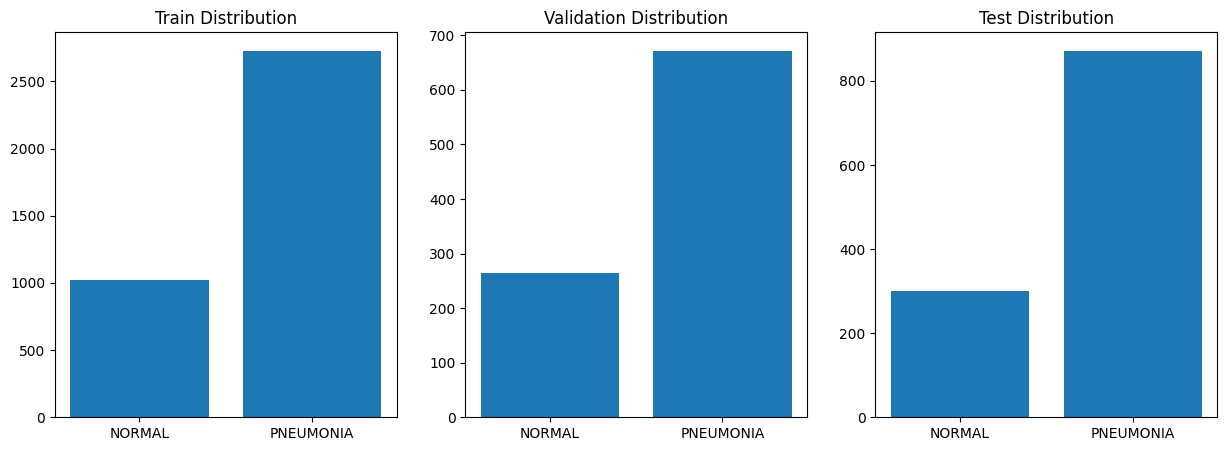

In [14]:
def display_distribution(ytrain, yval, testy):
    test = (np.count_nonzero(testy == "NORMAL"), np.count_nonzero(testy == "PNEUMONIA"))
    train = (np.count_nonzero(ytrain == "NORMAL"), np.count_nonzero(ytrain == "PNEUMONIA"))
    val = (np.count_nonzero(yval == "NORMAL"), np.count_nonzero(yval == "PNEUMONIA"))
    
    # Tracer les graphiques de distribution
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].bar(["NORMAL", "PNEUMONIA"], train)
    ax[0].set_title("Train Distribution")
    ax[1].bar(["NORMAL", "PNEUMONIA"], val)
    ax[1].set_title("Validation Distribution")
    ax[2].bar(["NORMAL", "PNEUMONIA"], test)
    ax[2].set_title("Test Distribution")
    plt.show()

display_distribution(ytrain, yval, testy)

#### Evaluation du modèle

In [12]:
# utilise la méthode evaluate de l'objet model pour évaluer les performances du modèle sur un ensemble de test.
print(model.evaluate(testx, testy))

37/37 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 0.3854 - precision: 0.8627 - recall: 0.9912
[0.36692824959754944, 0.9873853325843811, 0.8661971688270569]


37/37 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step


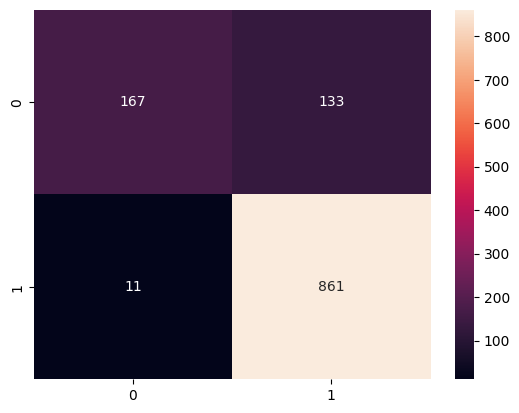

[[167 133]
 [ 11 861]]
recall :  0.9873853211009175
precision :  0.8661971830985915
f1score :  0.9228295819935691


In [13]:
# Predict the probabilities
y_pred = model.predict(testx)

# Convert probabilities to class labels
y_pred_label = np.round(y_pred).astype(int)

# Create the confusion matrix
cm = confusion_matrix(testy, y_pred_label)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(cm)
recall = recall_score(testy, y_pred_label)
precision = precision_score(testy, y_pred_label)
f1score = f1_score(testy, y_pred_label)
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

#### Validation curve core_size

In [8]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
xtrain, xval, ytrain, yval = train_test_split(trainx, trainy, test_size=0.2, random_state=1)

xtrain = xtrain / 255
print("xtrain normalized")
testx = testx / 255
print("testx normalized")
xval = xval / 255
print("xval normalized")

# For datasetY replace normal with 0 and pneumonia with 1 in order to have numeric values
ytrain = np.array([0 if y == "NORMAL" else 1 for y in ytrain])
testy = np.array([0 if y == "NORMAL" else 1 for y in testy])
yval = np.array([0 if y == "NORMAL" else 1 for y in yval])

NameError: name 'xtrain' is not defined

def create_model done
model defined
start validation_curve
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.6479 - recall: 0.8965
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 326ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - loss: 0.6654 - recall: 0.7150
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 477ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - loss: 0.7184 - recall: 0.9491
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 647ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 29s 663ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - loss: 0.7720 - recall: 0.8098
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 872ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 896ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - loss: 0.7430 - recall: 0.8325
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 0.5747 - recall: 0.7737
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 339ms/step
43/43 ━━━━━━━━━━━

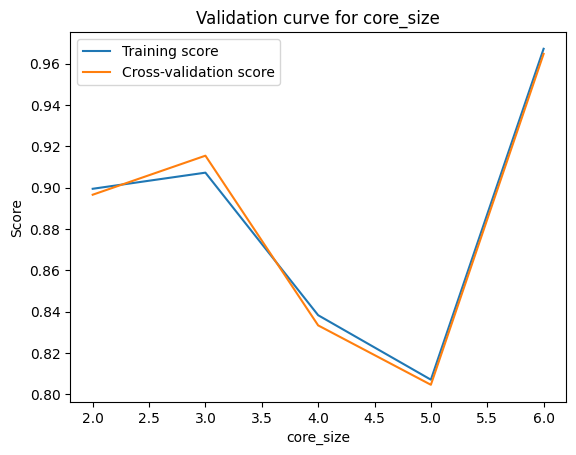

In [38]:
from sklearn.model_selection import validation_curve

# Define a function to create a model with a given core_size
def create_model(core_size):
    model = tf.keras.Sequential([
        layers.Input(shape=(200, 200, 1)),
        layers.Conv2D(256, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, core_size, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, core_size, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['recall'])
    return model

print("def create_model done")

# Wrap the model in a KerasClassifier
model = KerasClassifier(model=create_model, verbose=1, core_size=2)

print("model defined")

# Define the range of core_sizes to evaluate
core_sizes = [2, 3, 4, 5, 6]

print("start validation_curve")
# Compute the validation curve
train_scores, valid_scores = validation_curve(
    model, xtrain, ytrain, param_name="core_size", param_range=core_sizes, cv=3, scoring="recall"
)
print("start validation_curve")

# Plot the validation curve
plt.figure()
plt.plot(core_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(core_sizes, np.mean(valid_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for core_size')
plt.xlabel('core_size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

### Validation curve

In [ ]:
history = model.fit(xtrain,
                    ytrain,
                    validation_data=(xval, yval),
                    epochs=2)

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation precision
plt.figure(figsize=(12, 4))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot the training and validation recall
plt.figure(figsize=(12, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()